In [1]:
import numpy as np
random_state = 123
np.random.seed(random_state)
from matplotlib import pyplot as plt
import seaborn as sns
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
from os.path import abspath, join
from os import listdir
import tensorflow as tf
tf.random.set_seed(random_state)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from PIL import Image, ImageOps

2022-12-03 04:48:46.698495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 04:48:48.630595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 04:48:48.631161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 04:48:48.631172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

In [2]:
base_dir = 'data/archive/data'
pos_dir = join(base_dir, 'yes')
neg_dir = join(base_dir, 'no')

In [3]:
pos_imgs = listdir(pos_dir)
neg_imgs = listdir(neg_dir)

n_pos = len(pos_imgs)
n_neg = len(neg_imgs)
total_images = n_pos + n_neg
print(f"Total images in the dataset: {total_images}")

Total images in the dataset: 3000


## Glimpse of the data

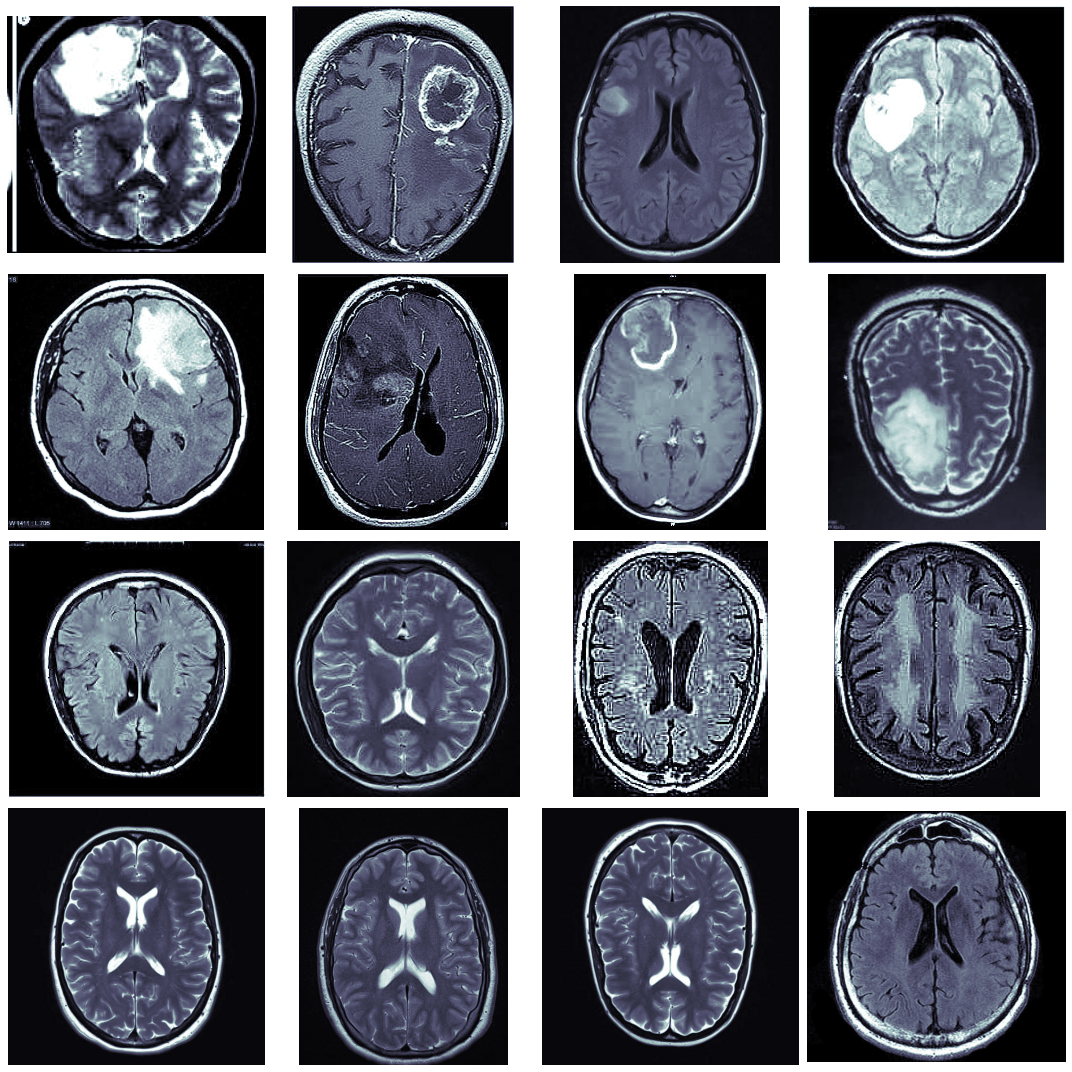

In [4]:
c_idx = 0
r_idx = 0
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i in range(16):
    file_name = None
    if i < 8:
        # Then load positive image
        file_name = join(pos_dir, pos_imgs[np.random.randint(0, n_pos)])
    else:
        file_name = join(neg_dir, neg_imgs[np.random.randint(0, n_neg)])
    
    tmp_img = ImageOps.grayscale(Image.open(file_name, mode='r'))
    axes[r_idx, c_idx].imshow(tmp_img, cmap="bone")
    axes[r_idx, c_idx].axis("off")
    
    if c_idx == 3:
        c_idx = 0
        r_idx += 1
    else:
        c_idx += 1
fig.tight_layout()
plt.show()

### Are all the images of same shape?

In [5]:
tmp_img.size

(428, 417)

In [6]:
pos_fname = join(pos_dir, pos_imgs[0])
prev_size = Image.open(pos_fname, mode='r').size

for i in range(1, len(pos_imgs)):
    pos_fname = join(pos_dir, pos_imgs[i])
    new_size = Image.open(pos_fname, mode='r').size
    if new_size != prev_size:
        print(f"The previous size was: {prev_size} while the new size is: {new_size}")
        break

The previous size was: (287, 348) while the new size is: (587, 630)


So, not all images are of same size. This needs to be addressed while creating the Pipeline. Perhaps we could use resize function in Pillow to ensure all images are resized to a common size. However, one caveat to the approach is, this approach would be fine for downscaling, and in case of upscaling, I might need to rethink about this. Although there are methods such as KNN, or other clustering techniques that can adapted to perform interpolation while resizing, there are better ways to handle this.

Find the minimal size from the set of all images

In [7]:
pos_fname = join(pos_dir, pos_imgs[0])
min_size = Image.open(pos_fname, mode='r').size

for i in range(1, len(pos_imgs)):
    pos_fname = join(pos_dir, pos_imgs[i])
    new_size = Image.open(pos_fname, mode='r').size
    if new_size < min_size:
        min_size = new_size

for i in range(len(neg_imgs)):
    neg_fname = join(neg_dir, neg_imgs[i])
    new_size = Image.open(neg_fname, mode='r').size
    if new_size < min_size:
        min_size = new_size

print(f"Minimum size from the set of all images: {min_size}")

Minimum size from the set of all images: (150, 198)


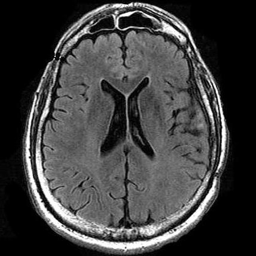

In [8]:
tmp_img.resize([256, 256])

In [9]:
pos_dir

'data/archive/data/yes'

In [10]:
batch_size = 50
buffer_size = 2

In [11]:
## Pipeline

tf_ds = keras.utils.image_dataset_from_directory(base_dir,
                                                 label_mode='binary', class_names = ['yes', 'no'],
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 image_size=[256, 256],
                                                 shuffle=True, seed=random_state,
                                                 validation_split=0.3, subset='both',
                                                 interpolation='bilinear')


Found 3000 files belonging to 2 classes.
Using 2100 files for training.
Using 900 files for validation.


2022-12-03 04:49:10.787393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-03 04:49:10.817446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-03 04:49:10.817775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:42:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-03 04:49:10.819615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [17]:
train_df = tf_ds[0].prefetch(buffer_size)
val_df = tf_ds[1].prefetch(buffer_size)

In [13]:
train_df

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

### Without data augmentation

In [14]:
model = Sequential([
                InputLayer(input_shape=[256, 256, 1], batch_size=batch_size),
                Rescaling(1./255),
                BatchNormalization(),
                Conv2D(filters=32, kernel_size=5, activation='relu'), # 252x252
                MaxPool2D(), # 126x126
                BatchNormalization(),
                Conv2D(filters=64, kernel_size=3, activation='relu'), # 124x124
                MaxPool2D(), # 62x62
                BatchNormalization(),
                Conv2D(filters=128, kernel_size=3, activation='relu'), # 60x60
                MaxPool2D(), # 30x30
                BatchNormalization(),
                Flatten(),
                Dense(128, activation='relu'),
                BatchNormalization(),
                Dense(10, activation='relu'),
                BatchNormalization(),
                Dense(1, activation='sigmoid')
            ])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (50, 256, 256, 1)         0         
                                                                 
 batch_normalization (BatchN  (50, 256, 256, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (50, 252, 252, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (50, 126, 126, 32)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (50, 126, 126, 32)       128       
 hNormalization)                                                 
                                                        

In [16]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.1,
                patience=10,
                verbose=1,
                mode='max',
                min_delta=0.0001,
                min_lr=1e-7
             )

terminate_nan_cb = tf.keras.callbacks.TerminateOnNaN()

es_cb = tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        min_delta=1e-4,
                        patience=10,
                        verbose=1,
                        mode='max',
                        restore_best_weights=True,
                        start_from_epoch=0
                    )

In [24]:
K.clip

<function keras.backend.clip(x, min_value, max_value)>

In [31]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
        r_pos = true_positives / (possible_positives + K.epsilon())
        r_neg = true_negatives / (possible_negatives + K.epsilon())
        return 0.5 * (r_pos + r_neg)

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip(1-y_true * 1-y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        predicted_negatives = K.sum(K.round(K.clip(1-y_pred, 0, 1)))
        p_pos = true_positives / (predicted_positives + K.epsilon())
        p_neg = true_negatives / (predicted_negatives + K.epsilon())
        return 0.5 * (p_pos + p_neg)
    
    p_macro = precision(y_true, y_pred)
    r_macro = recall(y_true, y_pred)
    return 2*((p_macro*r_macro)/(p_macro+r_macro+K.epsilon()))

In [32]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy', f1])

history = model.fit(train_df, batch_size=batch_size, epochs=20,
                    verbose=1, callbacks=[lr_schedule, terminate_nan_cb, es_cb],
                    validation_data=val_df, workers=16, use_multiprocessing=True)

Epoch 1/20
42/42 [==============================] - 9s 134ms/step - loss: 0.0023 - accuracy: 0.9995 - f1: 0.9995 - val_loss: 0.0826 - val_accuracy: 0.9833 - val_f1: 0.9835 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - 6s 127ms/step - loss: 0.0106 - accuracy: 0.9948 - f1: 0.9946 - val_loss: 0.1283 - val_accuracy: 0.9633 - val_f1: 0.9642 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - 6s 129ms/step - loss: 0.0037 - accuracy: 0.9986 - f1: 0.9986 - val_loss: 0.0758 - val_accuracy: 0.9822 - val_f1: 0.9824 - lr: 0.0010
Epoch 4/20
42/42 [==============================] - 6s 126ms/step - loss: 0.0017 - accuracy: 0.9995 - f1: 0.9995 - val_loss: 0.0788 - val_accuracy: 0.9822 - val_f1: 0.9824 - lr: 0.0010
Epoch 5/20
42/42 [==============================] - 6s 126ms/step - loss: 0.0011 - accuracy: 1.0000 - f1: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.9833 - val_f1: 0.9835 - lr: 0.0010
Epoch 6/20
42/42 [==============================] - 6s 126ms/step - loss: 0